In [322]:
import numpy as np 
import matplotlib.pyplot as plt

In [323]:
angle,time,time_str = [],[],[]
with open('angle_time.csv', 'r') as f:
    line = f.readline() 
    while line: 
        a,ts = line.split(',')
        h,m = ts.split(':')
        t = int(h)*60 + int(m)

        angle.append(float(a))
        time.append(t)
        time_str.append(ts)

        line = f.readline() 

angles = np.array(angle)
times = np.array(time) 
times = times - times.min()
times = times / times.max()

In [324]:
NIGHT = 102
END_SUNRISE = 87
DAY = 70

MAX_VAL = 200
VAL_MIN = 128
SAT_MIN = 96


HUE_POLY = 1.5
SAT_POLY = 2
VAL_POLY = 0.5

GREEN_START = (45+255)
GREEN_OFFSET = 85

STOP_HUE_CHANGE = (NIGHT - END_SUNRISE) / (NIGHT - DAY)

# Blue, Purple, Pink, Red
starting_hues = np.array([180,200,210,190])
# Blue, Pink, Orange, Gold
ending_hues = np.array([135, 145, 256+45, 256+40])

N_COLORS = starting_hues.shape[0]

# Convert from angle to percent
percents = (NIGHT-angles) / (NIGHT-DAY)
percents[percents < 0] = 0;percents

array([1.     , 0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 ,
       0.78125, 0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375,
       0.5625 , 0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  ,
       0.34375, 0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625,
       0.125  , 0.09375, 0.0625 , 0.03125, 0.     ])

In [325]:
import matplotlib.colors as mcolors

def draw_rectangle_gradient(ax, x1, y1, width, height, color1, color2, n=100):
    # Create an array of the linear gradient between the two colors
    gradient_colors = []
    for segment in np.linspace(0, width, n):
        interp_color = [(1 - segment / width) * color1[j] + (segment / width) * color2[j] for j in range(3)]
        if interp_color[0] > 1: 
            interp_color[0] -= 1

        gradient_colors.append(mcolors.hsv_to_rgb(interp_color))
    for i, color in enumerate(gradient_colors):
        ax.add_patch(plt.Rectangle((x1 + width/n * i, y1), width/n, height, color=color, linewidth=0, zorder=0))
    return ax

def green_filter(h): 
    filter_after = 0
    for h_ in h: 
        if h_ > GREEN_START:
            break 
        filter_after += 1 

    h[filter_after:] += GREEN_OFFSET

In [326]:
from math import sin
H=0; S=1; V=2
def update_leds(percent):  
    arr = [[0,0,0] for _ in range(N_COLORS)]

    s = ((255-SAT_MIN) * (1-pow(percent, SAT_POLY))) + SAT_MIN; 
    v = (MAX_VAL-VAL_MIN) * pow(percent, VAL_POLY)
    v = v+VAL_MIN if (percent != 0) else v
    
    percent = min(percent, STOP_HUE_CHANGE) / STOP_HUE_CHANGE; 
    for i in range(N_COLORS): 
        h = starting_hues[i] 
        hue_change = (ending_hues[i] - starting_hues[i]) 
        h += (pow(percent, HUE_POLY[i]) * hue_change)
        #h += (pow(percent, HUE_POLY) * HUE_CHANGE)

        #if (h > GREEN_START):
        #    h += GREEN_OFFSET

        arr[i][H] = h; 
        arr[i][S] = s; 
        arr[i][V] = 255; 

    arr = np.array(arr, dtype=np.float16)
    arr %= 256 
    arr /= 255
    return arr

def get_val(percent): 
    v = (MAX_VAL-VAL_MIN) * sin(percent)
    v = v+VAL_MIN
    return v

In [327]:
HUE_POLY = [1.5,1.5,4,1.5]

[135 145  45  40]
[135.5  145.6   45.2   40.16]
[180.8 200.8 210.9 190.8]
[180 200 210 190]


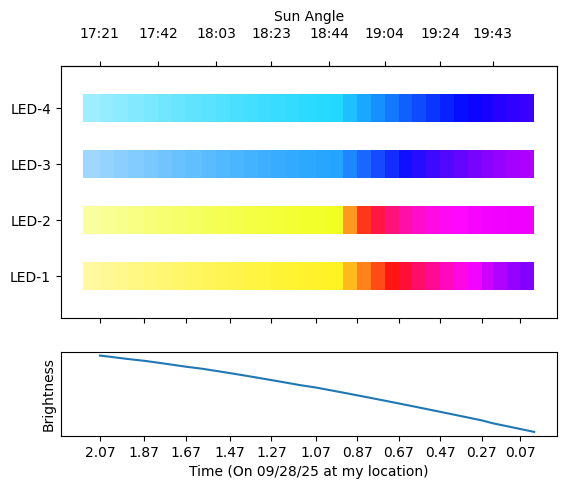

In [328]:
n = len(time_str)
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios': [3, 1]},)

print(ending_hues % 256)
ax = axes[0]
for i in range(times.shape[0]-1): 
    c1 = update_leds(percents[i])
    c2 = update_leds(percents[i+1])

    if i == 0: 
        print(c1[:,0] * 256)

    for j in range(N_COLORS): 
        draw_rectangle_gradient(ax, times[i], 3-j, times[i+1]-times[i], 0.5, c1[j], c2[j], n=1)

vals = [get_val(p) for p in percents[1:]]

print(c2[:,0] * 256)
print(starting_hues)

ax.set_ylim(-0.5, len(starting_hues))
ax.set_xticks(times[1::3], [f'{p/STOP_HUE_CHANGE:0.2f}' for p in percents[1::3]])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(times[1::4], time_str[1::4])
ax_top.set_xlabel("Sun Angle")
ax.set_yticks([0.25+i for i in range(4)], [f'LED-{i+1}' for i in range(4)])

v_ax = axes[1]
v_ax.plot(times[1:], vals)
v_ax.set_ylabel('Brightness')
v_ax.set_yticks([])
v_ax.set_xlabel("Time (On 09/28/25 at my location)")

plt.show()